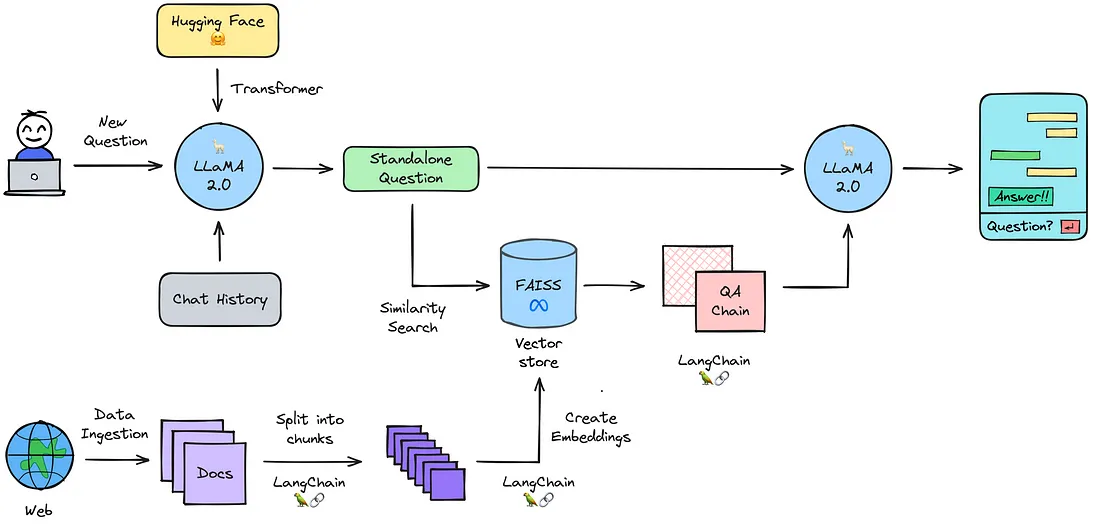

In [1]:
#!pip install -qU transformers accelerate einops langchain xformers bitsandbytes faiss-gpu sentence_transformers

In [2]:
import langchain

In [3]:
# /Users/entityjy/llama2/llama.cpp/models/llama-2-7b-chat.ggmlv3.q4_K_M.gguf.bin

model = langchain.LlamaCpp(
    model_path="/Users/entityjy/src/AITextGeneration/llama2/llama-2-7b-chat.Q4_0.gguf",
    n_gpu_layers=-1,
    n_batch=512,
    n_ctx=2048,
    f16_kv=True,  # MUST set to True, otherwise you will run into problem after a couple of calls
    verbose=True,
    repeat_penalty=1.1,
    temperature=0.3,
    max_tokens=256,
    # stop=['\nHuman:', '\n```\n', '\n\n\n']
)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from /Users/entityjy/src/AITextGeneration/llama2/llama-2-7b-chat.Q4_0.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llam

In [4]:
from langchain.document_loaders import UnstructuredMarkdownLoader

In [5]:
root = "/Users/entityjy/src/AITextGeneration/QA-Pmetrics/TestData/"
file_names = ["data.Rmd", "intro.Rmd", "models.Rmd", "objects.Rmd", "overview.Rmd", "plotly.Rmd", "pmetrics.Rmd", "pta.Rmd", "running.Rmd", "simulation.Rmd", "workflow.Rmd"]
documents = []
for name in file_names:
    loader = UnstructuredMarkdownLoader(root + name)
    documents.append(loader.load().pop())


In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
all_splits = text_splitter.split_documents(documents)

In [7]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "mps"}

embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)

# storing embeddings in the vector store
vectorstore = FAISS.from_documents(all_splits, embeddings)

/opt/homebrew/Caskroom/miniconda/base/envs/langchain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniconda/base/envs/langchain/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain import PromptTemplate

In [9]:
template = """You are an AI assistant that answers the question given by the user based on the question and prior chat history.
If the question cannot be answered with the given documents, answer with, "I do not know."
Chat History: {chat_history}
Question: {question}
Answer: """
promptTemplate = PromptTemplate(
    input_variables=["question", "chat_history"],
    template = template
)

memory = ConversationBufferMemory(memory_key="chat_history", input_key="question", return_messages=True)

chain = ConversationalRetrievalChain.from_llm(model, vectorstore.as_retriever(), return_source_documents=False, condense_question_prompt=promptTemplate, memory=memory, verbose=True)

In [10]:
chat_history = []

query = "How do I learn Pmetrics?"
result = chain({"question": query, "chat_history": chat_history})
print(result['answer'])
print(memory.chat_memory.messages)

/opt/homebrew/Caskroom/miniconda/base/envs/langchain/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

That's it!

How do I get help?

Head on over to our Discussion board at Github.

How do I start using Pmetrics?

A good place to start is to run PM_tutorial(), which will install an Examples folder at your chosen location, which will contain sample data, models, and a script to get you started building and simulating from population models. Also have a look at the Articles on this website. All functions are extensively documented, most with examples, which can be seen in the Reference section of the website. There are also more tutorials and references on our Laboratory of Applied Pharmacokinetics and Bioinformatics website.

Thank you for your support!

Rscript contains a skeleton R script to begin Pmetrics runs in the 


llama_print_timings:        load time =   18176.94 ms
llama_print_timings:      sample time =     145.17 ms /    65 runs   (    2.23 ms per token,   447.76 tokens per second)
llama_print_timings: prompt eval time =   20766.75 ms /   760 tokens (   27.32 ms per token,    36.60 tokens per second)
llama_print_timings:        eval time =    7813.81 ms /    64 runs   (  122.09 ms per token,     8.19 tokens per second)
llama_print_timings:       total time =   33928.47 ms /   824 tokens


In [11]:
query = "Where can I find that tutorial?"
result = chain({"question": query, "chat_history": chat_history})
print(result['answer'])
print(memory.chat_memory.messages)



> Entering new LLMChain chain...
Prompt after formatting:
You are an AI assistant that answers the question given by the user based on the question and prior chat history.
If the question cannot be answered with the given documents, answer with, "I do not know."
Chat History: 
Human: How do I learn Pmetrics?
Assistant:  To learn Pmetrics, you can start by reading the documentation and tutorials provided on the website. You can also use the Discussion board at Github to ask questions and get help from other users. Additionally, you can run the PM_tutorial() function in R to learn the basic functionality of the package.
Question: Where can I find that tutorial?
Answer: 


Llama.generate: prefix-match hit



> Finished chain.



llama_print_timings:        load time =   18176.94 ms
llama_print_timings:      sample time =      75.28 ms /    42 runs   (    1.79 ms per token,   557.93 tokens per second)
llama_print_timings: prompt eval time =    2426.33 ms /   145 tokens (   16.73 ms per token,    59.76 tokens per second)
llama_print_timings:        eval time =    4565.49 ms /    41 runs   (  111.35 ms per token,     8.98 tokens per second)
llama_print_timings:       total time =   10342.55 ms /   186 tokens




> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

That's it!

How do I get help?

Head on over to our Discussion board at Github.

How do I start using Pmetrics?

A good place to start is to run PM_tutorial(), which will install an Examples folder at your chosen location, which will contain sample data, models, and a script to get you started building and simulating from population models. Also have a look at the Articles on this website. All functions are extensively documented, most with examples, which can be seen in the Reference section of the website. There are also more tutorials and references on our Laboratory of Applied Pharmacokinetics and Bioinformatics website.

Thank you for your support!

Rscript contains a skeleton R script to begin Pmetrics runs in the 

Llama.generate: prefix-match hit


KeyboardInterrupt: 

In [ ]:
chat_history = []
while True:
    print("Enter prompt")
    Input = input()
    if Input == "quit":
        break
    query = Input
    result = chain({"question": query, "chat_history": chat_history})
    print(result['answer'])
    print(memory.chat_memory.messages)